In [1]:
import gym
import numpy as np
import random

In [2]:
"""
I implement the discretize function in the agent class

this is just a regular Q-learning implementation
"""
from collections import defaultdict
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
class Qlearning():
    def __init__(self,
                env,gamma,epsilon,alpha, n_states):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.q = defaultdict(lambda : np.zeros(env.action_space.n))
        self.n_states = n_states
        
    def discretize(self, state):
        env_low = self.env.observation_space.low
        env_high = self.env.observation_space.high
        env_dx = (env_high - env_low) / self.n_states
        pos = int((state[0] - env_low[0])/env_dx[0])
        v = int((state[1] - env_low[1])/env_dx[1])
        return frozenset([pos,v])
        
    def choose_action(self, state):
        epsilon = self.epsilon
        if np.random.random() < epsilon:
            return env.action_space.sample()
        else:
            return np.argmax(self.q[state])
    
    def update_q(self, state, action, next_state,  reward):
        next_action = np.argmax(self.q[next_state])
        self.q[state][action] += self.alpha * (reward + self.gamma * self.q[next_state][next_action] - self.q[state][action])
        
    def run_step(self, state, action):
        next_state_c, reward, done, _ = self.env.step(action)
        next_state = self.discretize(next_state_c)       
        next_action = self.choose_action(next_state)
        self.update_q(state,action,next_state,reward)
        return next_state, next_action,reward,done
        
    def run_episode(self):
        epsilon = self.epsilon
        alpha = self.alpha
        episode_return = 0
        state = self.discretize(self.env.reset())
        
        while True:
            action = self.choose_action(state)
            state, action, reward,done = self.run_step(state,action)
            episode_return+= reward
            if done:
                break      
        return episode_return
    
    def learn_task(self, n):
        returns = []
        for i in tqdm(range(n)):
            episode_return = self.run_episode()
            returns.append(episode_return)
        return returns
    
    def show(self):
        state = self.discretize(self.env.reset())
        episode_return = 0
        while True:
            action = self.choose_action(state)
            state, action, reward,done = self.run_step(state,action)
            env.render()
            episode_return+= reward
            if done:
                break
        return episode_return
    

In [3]:
"""
Train the agent
"""

env = gym.make('MountainCar-v0')
q_agent = Qlearning(env , gamma = 1, epsilon = 0.1,
           alpha = 0.1, n_states = 30)

q_returns = q_agent.learn_task(20000)

100%|█████████████████████████████████████| 20000/20000 [04:17<00:00, 77.69it/s]


In [4]:
"""Take a look on the best performance"""
np.max(q_returns)

-89.0

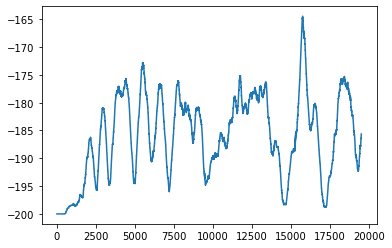

In [5]:
from matplotlib import pyplot as plt
from scipy.interpolate import pchip
import pandas as pd


"""
Prepare moving average function and success rate function


success rate function is given a set of episode results,
compute the percentage of reaching the goals
"""

def moving_average(a,n):
    N=len(a)
    return np.array([np.mean(a[i:i+n]) for i in np.arange(0,N-n+1)])

def success_rate(results):
    count = 0.0
    total = float(len(results))
    for r in results:
        if r > -200:
            count += 1.0
    return (count/total)

Q_smooth = moving_average(q_returns, 500)
plt.plot(Q_smooth)

In [7]:
"""
train the agent for another 1000 rounds to see how does the agent perform

This is not so ideal, what if we switch to Expected Sarsa?
"""

q_test = q_agent.learn_task(1000)


100%|███████████████████████████████████████| 1000/1000 [00:12<00:00, 82.99it/s]


In [8]:
"""
After the q-learning agent converage, the success rate is as follow
"""
print(success_rate(q_test))

0.586


In [9]:
"""
Implement the Expected Sarsa for mountain car
"""

from collections import defaultdict
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

class ESarsa():
    def __init__(self,
                env,gamma,epsilon,alpha, n_states):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.q = defaultdict(lambda : np.zeros(env.action_space.n))
        self.n_states = n_states
    
    
    def discretize(self, state):
        env_low = self.env.observation_space.low
        env_high = self.env.observation_space.high
        env_dx = (env_high - env_low) / self.n_states
        pos = int((state[0] - env_low[0])/env_dx[0])#'/'
        v = int((state[1] - env_low[1])/env_dx[1])
        return frozenset([pos,v])
        
    def choose_action(self, state):
        epsilon = self.epsilon
        if np.random.random() < epsilon:
            return env.action_space.sample()
        else:
            return np.argmax(self.q[state])
        
    def action_possibility(self, state):
        epsilon = self.epsilon
        P = []
        actions = self.q[state]
        n = env.action_space.n
        for i in range(0,n):
            if i == np.argmax(actions):
                P.append((epsilon/n) + 1 - epsilon)
            else:
                P.append(epsilon/n)
        return P
            
    def update_q(self, state, action, next_state, next_action, reward):
        P = self.action_possibility(next_state)        
        V = P * self.q[next_state]
        self.q[state][action] += self.alpha * (reward + self.gamma*sum(V) - self.q[state][action])
        
          
    def run_step(self, state, action):
        next_state_c, reward, done, _ = self.env.step(action)
        next_state = self.discretize(next_state_c)       
        next_action = self.choose_action(next_state)
        self.update_q(state,action,next_state,next_action,reward)
        return next_state, next_action,reward,done
        
    def run_episode(self):
        epsilon = self.epsilon
        alpha = self.alpha
        episode_return = 0
        state = self.discretize(self.env.reset())
        
        while True:
            action = self.choose_action(state)
            state, action, reward,done = self.run_step(state,action)
            episode_return+= reward
            if done:
                break      
        return episode_return
    
    def learn_task(self, n):
        returns = []
        for i in tqdm(range(n)):
            episode_return = self.run_episode()
            returns.append(episode_return)
        return returns
    
    def show(self):
        state = self.discretize(self.env.reset())
        episode_return = 0
        while True:
            action = self.choose_action(state)
            state, action, reward,done = self.run_step(state,action)
            env.render()
            episode_return+= reward
            if done:
                break
        return episode_return

In [10]:
"""Train the Expected Sarsa Agent"""

env = gym.make('MountainCar-v0')
e_agent = ESarsa(env , gamma = 1, epsilon = 0.01,
           alpha = 0.1, n_states = 30)

E = e_agent.learn_task(20000)

100%|█████████████████████████████████████| 20000/20000 [04:25<00:00, 75.36it/s]


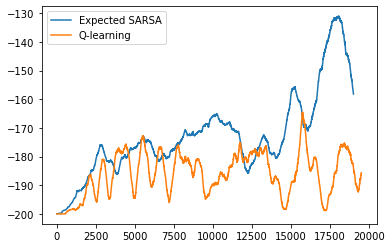

In [11]:
E_sarsa_smooth = moving_average(E, 1000)
plt.plot(E_sarsa_smooth,label="Expected SARSA")
plt.plot(Q_smooth,label = "Q-learning")
plt.legend()
plt.show()

In [12]:
e_test = e_agent.learn_task(1000)
e_result = 0

100%|███████████████████████████████████████| 1000/1000 [00:14<00:00, 69.74it/s]


In [16]:
print("The success rate of q-learning agent after 20000 runs training is: \t",success_rate(q_test))
print("The success rate of expected Sarsa agent after 20000 runs training is: \t",success_rate(e_test))

The success rate of q-learning agent after 20000 runs training is: 	 0.586
The success rate of expected Sarsa agent after 20000 runs training is: 	 0.842


In [20]:
"""
The following command can be used for a test run
"""

# q_agent.show()
# e_agent.show()

'\nThe following command can be used for a test run\n'